In [1]:
# import necessary packages for the EDA process
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2

%matplotlib inline

plt.rcParams['figure.figsize'] = [18, 6]

train = pd.read_csv('training_images_size.csv', sep='\t')
test = pd.read_csv('testing_images_size.csv', sep='\t')

### Overview Statistics 

#### Training Dataset

In [2]:
train.head()

,imagepath,type,heights,widths,channels
0,train/Type_1/0.jpg,Type_1,3264,2448,3
1,train/Type_1/1013.jpg,Type_1,3264,2448,3
2,train/Type_1/1014.jpg,Type_1,4128,3096,3
3,train/Type_1/1019.jpg,Type_1,3264,2448,3
4,train/Type_1/1023.jpg,Type_1,4128,3096,3


In [3]:
train.describe()

,heights,widths,channels
count,1481.000000,1481.000000,1481.0
mean,3661.709656,2783.655638,3.0
std,501.958655,384.097922,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,3264.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 5 columns):
imagepath    1481 non-null object
type         1481 non-null object
heights      1481 non-null int64
widths       1481 non-null int64
channels     1481 non-null int64
dtypes: int64(3), object(2)
memory usage: 57.9+ KB


#### Testing Dataset

In [5]:
test.head()

,heights,widths,channels
0,2448,3264,3
1,3264,2448,3
2,4128,3096,3
3,3264,2448,3
4,4128,3096,3


In [6]:
test.describe()

,heights,widths,channels
count,503.000000,503.000000,503.0
mean,3679.968191,2806.556660,3.0
std,536.263239,419.989063,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,4128.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


### Correlation Between Height and Width in All Images 

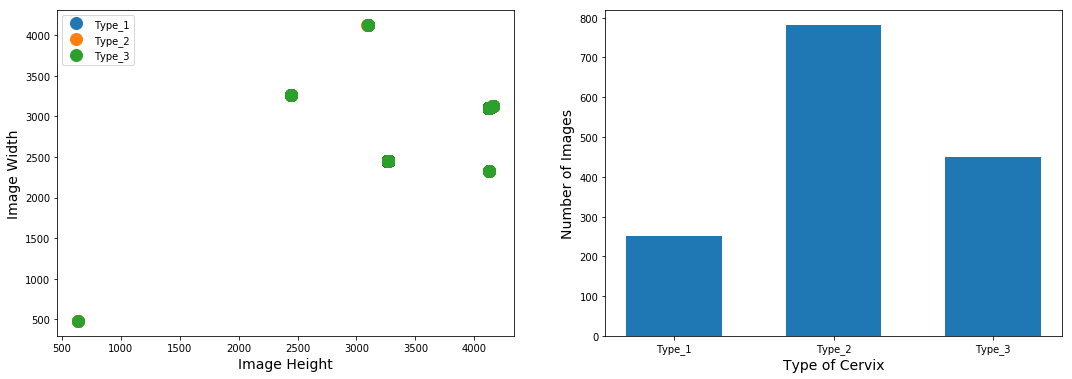

In [7]:
#Generate a scatter plot of width v.s height for all images of all cervix type
#Compare the number of images in each cervix type
groups = train.groupby('type')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18,6)
for name, group in groups:
    ax1.plot(group.heights, group.widths, marker='o', linestyle='', ms=12, label=name)
    ax1.set_xlabel('Image Height', fontsize=14)
    ax1.set_ylabel('Image Width', fontsize=14)
ax1.legend(loc='upper left')

count_type = np.unique(train['type'], return_counts=True)
ax2.bar(count_type[0], count_type[1], width=0.6)
ax2.set_ylabel('Number of Images', fontsize=14)
ax2.set_xlabel('Type of Cervix',  fontsize=14)

plt.show()

In [8]:
train.groupby('type')['imagepath'].count()

type
Type_1    250
Type_2    781
Type_3    450
Name: imagepath, dtype: int64

There are 1481 images in the whole training dataset, in which 781 images are classified as Type_2, 450 images are Type_3 and 250 images belongs to Type_1. In addition, all three cervix types seem to have 5 different groups of image sizes as shown in the scatter plot above. However, we can check if there is indeed 5 different image sizes by combining the 3 columns: heights, widths, and chanels together, count the number of unique pairs. 

### Investigate Different Image Sizes

There are  8 unique image sizes.


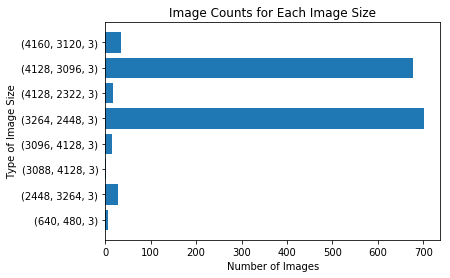

In [9]:
train['size'] = list(zip(train['heights'],train['widths'],train['channels']))
print ('There are ', train['size'].nunique(), 'unique image sizes.' )

size_labels, count_sizes = np.unique(train['size'], return_counts=True)

size_labels = [str(i) for i in size_labels]
plt.barh(size_labels, count_sizes)
plt.xlabel('Number of Images')
plt.ylabel('Type of Image Size')
plt.title('Image Counts for Each Image Size')
plt.show()

The majority of image sizes fall under the two categories: (4128, 3096, 3) and (3264, 2448, 3). Now, let's take a look how the image sizes are distributed within each cervix type. 

In [10]:
group_sizes = train.groupby(['type', 'size'])['imagepath'].count().reset_index(name='count')
group_sizes.head()

,type,size,count
0,Type_1,"(640, 480, 3)",2
1,Type_1,"(2448, 3264, 3)",2
2,Type_1,"(3096, 4128, 3)",3
3,Type_1,"(3264, 2448, 3)",85
4,Type_1,"(4128, 2322, 3)",2


<Figure size 1080x576 with 0 Axes>

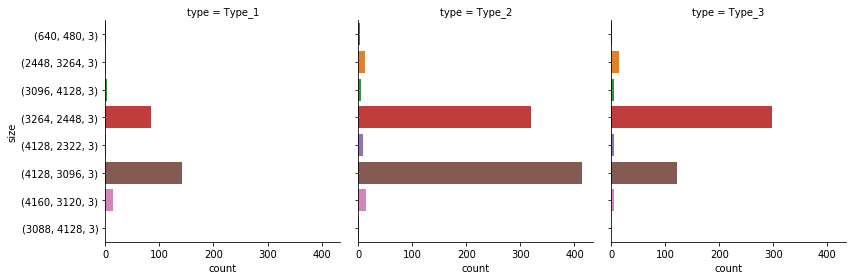

In [11]:
plt.figure(figsize=(15,8))
ax = sns.factorplot( x='count', y='size',col='type', data=group_sizes, kind='bar')

Type_1 and Type _2 cervix images seem to have the same distribution in terms of image sizes. Type_3 has a different ratio of (3264, 2448,3)/(4128, 3096, 3). However, the two sizes: (3264, 2448,3) and (4128, 3096, 3) are the dominant image sizes for all types. 

### Convert RGB to Grayscale

Since all images have channels=3, it would be much simplier for us to build a model using less number of channels. This can be done by coverting all images from RGB scale to grayscale using cv2 module. Grayscale images's complexcity is inherently lower than that of color images; and thus converting from color scale to grayscale can help us reduce the model complexity and computational time tremedously. Let's convert all images in the training dataset to grayscale using the tools available in the cv2 module. 

In [12]:
#define a function to transform all images from color to normalized grayscale
def image_transformation(paths, rescale_dim):
    transformed_imgs = []
    for path in paths:
        #read image from provided path
        img = cv2.imread(path)
        #resize image to the desired scale, i.e(100,100), using the default cv2.INTER_LINEAR
        resize = cv2.resize(img, (rescale_dim, rescale_dim)) 
        #change from RGB to grayscale
        grayscale = cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY).astype('float')
        #reshape image from (100,100) to (1,10000)
        normalized = cv2.normalize(grayscale, None, 0.0, 1.0, cv2.NORM_MINMAX)
        transformed_img = normalized.reshape(1,np.prod(normalized.shape))
        #scale to the norm vector
        transformed_img = transformed_img/np.linalg.norm(transformed_img)
        transformed_imgs.append(transformed_img)
    return transformed_imgs

In [13]:
#Convert all images to grayscale images
grayscales = image_transformation(train.imagepath.values, 100)

#### NOTE:
Since the step of converting all images from RGB to grayscale with flattening takes quite a bit of time (~5 mins), a new dataframe which includes the grayscale array of each image and their type label is generated and written out to a csv file for later use. 

In [14]:
grayscale_df = pd.DataFrame({'grayscale': grayscales, 'type': train.type.values})
grayscale_df.to_csv('grayscales_training.csv')

In [15]:
grayscales = np.array(grayscales).squeeze()

In [16]:
grayscales.shape

(1481, 10000)

In [17]:
grayscales[:5]

array([[9.84409071e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.76399950e-03, 9.23507309e-03, 1.05426941e-02, ...,
        0.00000000e+00, 8.17263105e-05, 1.63452621e-04],
       [1.71990766e-02, 1.72787019e-02, 1.71194512e-02, ...,
        1.09086736e-02, 1.02716707e-02, 9.55504253e-03],
       [1.38910835e-02, 1.30807703e-02, 1.19231800e-02, ...,
        3.58852989e-03, 3.35701184e-03, 4.86187921e-03],
       [2.09204707e-03, 4.18409415e-03, 5.87382448e-03, ...,
        3.62085070e-03, 1.28741358e-03, 3.21853396e-04]])

In [18]:
#Decompose 10000 elements of each image array into 2 pca components and visualize
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
labels = pca.fit_transform(grayscales)

Text(0,0.5,'Feature Space for 2nd PCA component')

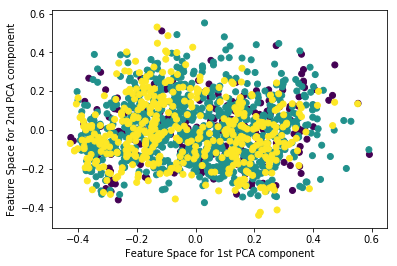

In [19]:
#pca components visualization with color labelling for each cervix type
train['label'] = [val.split('_')[-1] for val in train.type.values]

plt.scatter(labels[:, 0], labels[:,1], c=train.label.values)
plt.xlabel('Feature Space for 1st PCA component')
plt.ylabel('Feature Space for 2nd PCA component')

It appears that there is quite a bit of overlapping between different vervix types by convering the grayscale images into 2 PCA components. Let's try converting the grayscale dataset into 3 components to see if we can obtain any cluster separation. 

In [20]:
pca = PCA(n_components = 3)
labels = pca.fit_transform(grayscales)

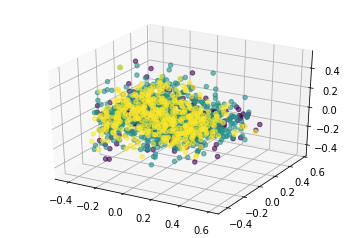

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(labels[:, 0], labels[:,1], labels[:, 2], c=train.label.values, alpha=0.6)

By converting the grayscale dataset into 3 PCA component, we did not see much of a cluster distinction between the three cervix types. 